# Investigating Movie Performance

### Team 2: Yashharan Babra, Kevin Brereton, Nicole Caballero, Yesha Patel

The objective of this project is to analyze movie data to answer the following questions:  
  
1. How does the director of a movie affect its rating?  
2. How do the ratings of a movie affect its income?  
3. How do the lead actors of a movie affect its income?  

This will be done using data from IMDB, downloaded from Kaggle in CSV format, as well as web scraping the Metacritic website.

### HTTP code

First, make a function which gets a page from Metacritic's "Movie Releases by Score" list. The input to the function is page number of movies on the "Movie Releases by Score" page. ie. page 0 gets an html page for the top 100 movies, page 1 gets movies 101-200, etc.

Notice that there are some extra headers that are added to the requests.get function. This is because Metacritic will 403 error out anybody who accesses the site without the user-agent http header.

There is also some code added which guarantees that we got back html and didn’t get a 400 error, in case the url of the page has been changed.

In [1]:
from datetime import date, datetime
from typing import Optional, Iterable, Dict, Union
import pandas as pd
from bs4 import BeautifulSoup, element
from time import sleep
import requests
import numpy as np



def getMetaCriticPage(page_num:int)->Optional[str]:
    meta_critic_page_headers={
        "accept": "text/html",
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36"
    }
    http_req=requests.get(f"https://www.metacritic.com/browse/movies/score/metascore/all/filtered?sort=desc&page={page_num}",headers=meta_critic_page_headers)
    if http_req.status_code!=200 or "text/html" not in http_req.headers["content-type"]:
#         wait 25 seconds and try again. Metacritic will sometimes reject your request, even if you only request every 5 seconds. to prevent that, try again.
        sleep(25)
        http_req=requests.get(f"https://www.metacritic.com/browse/movies/score/metascore/all/filtered?sort=desc&page={page_num}",headers=meta_critic_page_headers)
        if http_req.status_code!=200 or "text/html" not in http_req.headers["content-type"]:
            return None
    
    return http_req.text

## Web Scraping Code

In this code, we use BeautifulSoup to scrape the data from Metacritic. The entry function of this code is the "getMetaCriticValues" function. In that function, the input is the "Movie Releases by Score" html page, and the output is a generator. That generator yields a dictionary for each movie in the html page. So if the first Metacritic page is the input, the output is a generator, which creates a dictionary for the each movie in the top 100. 

The reason that we used a generator rather than a list was to prevent unnecessary intermediate objects taking up memory (ie. a dict for all 10,000 movies). 

There is also minor text normalization in this code. This is because we wanted to remove all website specific quirks from the data before performing any real data cleaning.

In [2]:
def normalizeTitle(title):
    return title.strip()


def findLastPage(html:str)->int:
    return int(BeautifulSoup(html,'html.parser').find("li",{"class":"page last_page"}).find("a",{"class":"page_num"}).text)
    

def findMetaCriticReleaseDate(movie:BeautifulSoup)->Union[datetime,np.float64]:
    dateText=movie.find("div",{"class":"clamp-details"}).find("span").text
    normalizedDateText=dateText.strip()
    if normalizedDateText =="TBA":
        return np.nan
    return datetime.strptime(normalizedDateText,"%B %d, %Y")


def findMetaCriticScore(movie:BeautifulSoup,score_str:str)->float:
    span=movie.find("span",text=score_str)
    text=str(span.next_sibling.next_sibling.text).strip()
    try:
        return float(text)
    except:
        if text =="tbd":
            return np.nan
        else:
            raise ValueError("unable to find meta critic score, and was not tbd. Most likely the website layout changed")


def getMetaCriticValues(html:str)->Iterable[Dict]:
    soup=BeautifulSoup(html,'html.parser')
    for single_movie in soup.find_all("td",{"class":"clamp-summary-wrap"}):
        release_date=findMetaCriticReleaseDate(single_movie)
        year= release_date.year if type(release_date) == datetime else np.nan
        title=normalizeTitle(str(single_movie.find("h3").text))
        critic_rating=findMetaCriticScore(single_movie,"Metascore:")
        user_rating=findMetaCriticScore(single_movie,"User Score:")
        yield {
            "date_published":release_date,
            "title":title,
            "year":year,
            "metacritic_critic_rating":critic_rating/10,
            "metacritic_user_rating":user_rating
        }



## Main Webscraping Script

Now that those functions were created, we then make the code that web scrapes every page on Metacritic’s "Movie Releases by Score" page. To do that, first we check to see how many "Movie Releases by Score" pages there are on Metacritic. Then we iterate through each "Movie Releases by Score" page and call the getMetaCriticValues function for that page. At the end, we have a dataframe which holds all of the Metacritic data we need.

Note that after each html page it gets, it sleeps for 5 seconds. This is to prevent Metacritic from blocking us.

In [3]:
def iterateThroughMetaCriticValues()->Iterable[Dict]:
    last_num=findLastPage(getMetaCriticPage(0))
    
#     only go to last num, since page count in api starts at 0, but on webpage starts at 1.
    for page_num in range(0,last_num,1):
        page=getMetaCriticPage(page_num)
        if page is not None:
            yield from getMetaCriticValues(page)
            sleep(5)

metacritic=pd.DataFrame(iterateThroughMetaCriticValues(),columns=['date_published','title','year','metacritic_critic_rating','metacritic_user_rating'])
metacritic

,date_published,title,year,metacritic_critic_rating,metacritic_user_rating
0,1941-09-04,Citizen Kane,1941.0,10.0,8.5
1,1972-03-11,The Godfather,1972.0,10.0,9.2
2,1954-09-01,Rear Window,1954.0,10.0,8.8
3,1943-01-23,Casablanca,1943.0,10.0,8.9
4,2014-07-11,Boyhood,2014.0,10.0,7.6
...,...,...,...,...,...
13589,1987-08-22,The Garbage Pail Kids Movie,1987.0,0.1,0.8
13590,2015-06-05,United Passions,2015.0,0.1,0.7
13591,1996-01-12,Bio-Dome,1996.0,0.1,7.2
13592,2005-08-12,Chaos,2005.0,0.1,2.3


## IMDB Data  
IMDB data was obtained by downloading a CSV file from Kaggle (https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset)

In [4]:
import re

def parse_money(string_money):
    # Make sure money is in dollars. Otherwise ignore since it can't be compared with other movies.
    if re.findall('\$', string_money):
        money = re.findall('\d{1,3}', string_money)
        money = int("".join(money))
    else: 
        money = np.nan
    return money

def parse_date(string_date):
    # Check that date is in valid format and if so, convert to datetime object
    if re.search('^\d{4}-\d{2}-\d{2}', string_date):
        date = datetime.strptime(string_date, "%Y-%m-%d")
    else:
        date = np.nan
    return date

def parse_year(string_year):
    # Check that year is in valid format and if so, convert to int
    if re.search('^\d{4}', string_year):
        year = int(string_year)
    else:
        year = np.nan
    return year

def convert_to_list(string_format):
    if string_format == "None":
        return []
    else:
        return string_format.split(",")

# usecols specifies columns we want to add from the csv to our dataframe
# converters specifies how we want to transform string values before adding to the dataframe
imdb = pd.read_csv("IMDB_movies.csv", usecols=['title','year','date_published','genre','duration','country','language','director','actors','avg_vote','votes','budget','usa_gross_income','worldwide_gross_income'], parse_dates=['date_published'], date_parser=parse_date, converters={'year':parse_year, 'genre':convert_to_list, 'duration':int, 'country':convert_to_list, 'language':convert_to_list, 'director':convert_to_list, 'actors':convert_to_list, 'avg_vote':float, 'votes':int, 'budget':parse_money, 'usa_gross_income':parse_money, 'worldwide_gross_income':parse_money})
imdb

,title,year,date_published,genre,duration,country,language,director,actors,avg_vote,votes,budget,usa_gross_income,worldwide_gross_income
0,Miss Jerry,1894.0,1894-10-09,[Romance],45,[USA],[],[Alexander Black],"[Blanche Bayliss, William Courtenay, Chaunce...",5.9,154,NaN,NaN,NaN
1,The Story of the Kelly Gang,1906.0,1906-12-26,"[Biography, Crime, Drama]",70,[Australia],[],[Charles Tait],"[Elizabeth Tait, John Tait, Norman Campbell,...",6.1,589,2250.0,NaN,NaN
2,Den sorte drøm,1911.0,1911-08-19,[Drama],53,"[Germany, Denmark]",[],[Urban Gad],"[Asta Nielsen, Valdemar Psilander, Gunnar He...",5.8,188,NaN,NaN,NaN
3,Cleopatra,1912.0,1912-11-13,"[Drama, History]",100,[USA],[English],[Charles L. Gaskill],"[Helen Gardner, Pearl Sindelar, Miss Fieldin...",5.2,446,45000.0,NaN,NaN
4,L'Inferno,1911.0,1911-03-06,"[Adventure, Drama, Fantasy]",68,[Italy],[Italian],"[Francesco Bertolini, Adolfo Padovan]","[Salvatore Papa, Arturo Pirovano, Giuseppe d...",7.0,2237,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85850,Le lion,2020.0,2020-01-29,[Comedy],95,"[France, Belgium]",[French],[Ludovic Colbeau-Justin],"[Dany Boon, Philippe Katerine, Anne Serra, ...",5.3,398,NaN,NaN,3507171.0
85851,De Beentjes van Sint-Hildegard,2020.0,2020-02-13,"[Comedy, Drama]",103,[Netherlands],"[German, Dutch]",[Johan Nijenhuis],"[Herman Finkers, Johanna ter Steege, Leonie ...",7.7,724,NaN,NaN,7299062.0
85852,Padmavyuhathile Abhimanyu,2019.0,2019-03-08,[Drama],130,[India],[Malayalam],[Vineesh Aaradya],"[Anoop Chandran, Indrans, Sona Nair, Simon ...",7.9,265,NaN,NaN,NaN
85853,Sokagin Çocuklari,2019.0,2019-03-15,"[Drama, Family]",98,[Turkey],[Turkish],[Ahmet Faik Akinci],"[Ahmet Faik Akinci, Belma Mamati, Metin Keçe...",6.4,194,NaN,NaN,2833.0


## Merging IMDB and Metacritic Data  
  
We chose to merge on the combination of movie title and year as there are cases where the same movie title is used in more than one year, such as when remakes of rmovies are made. So merging on the title alone is not enough. We chose to merge on year rather than the release date as there are cases in IMDB data where the year in the release date does not match the release year, and does not match the release date from Metacritic. However, the release years match for the same movies acorss IMDB and Metacritic. For example, Frankenstein in IMDB data has release date of 1935-12-02 but release year of 1931, while release date in Metacritic is 1931-11-21.

In [5]:
# The purpose of retrieving data from Metacritic is to get the ratings. The dataframe only holds rating values and movie information, which will be used to merge with IMDB data. So if any piece of information is missing, those rows can be removed as they are not useful to us. 
metacritic = metacritic.dropna()

# Drop release date from IMDB since there is a duplicate column from Metacritic, which has a more accurate release date
imdb = imdb.drop(columns='date_published')

merged = pd.merge(imdb, metacritic, on=['title', 'year'])
merged

,title,year,genre,duration,country,language,director,actors,avg_vote,votes,budget,usa_gross_income,worldwide_gross_income,date_published,metacritic_critic_rating,metacritic_user_rating
0,Intolerance,1916.0,"[Drama, History]",163,[USA],[English],[D.W. Griffith],"[Lillian Gish, Mae Marsh, Robert Harron, F....",7.8,13875,385907.0,NaN,NaN,1916-09-05,9.9,8.9
1,Frankenstein,1931.0,"[Drama, Horror, Romance]",70,[USA],"[English, Latin]",[James Whale],"[Colin Clive, Mae Clarke, John Boles, Boris...",7.8,63315,291000.0,NaN,1626.0,1931-11-21,9.1,8.5
2,Freaks,1932.0,"[Drama, Horror]",64,[USA],"[English, German, French]",[Tod Browning],"[Wallace Ford, Leila Hyams, Olga Baclanova, ...",7.9,41173,310607.0,NaN,4072.0,1932-02-20,8.0,8.3
3,King Kong,1933.0,"[Adventure, Horror, Sci-Fi]",100,[USA],[English],"[Merian C. Cooper, Ernest B. Schoedsack]","[Fay Wray, Robert Armstrong, Bruce Cabot, F...",7.9,77507,670000.0,NaN,651.0,1933-04-07,9.0,8.4
4,Fantasia,1940.0,"[Animation, Family, Fantasy]",125,[USA],[English],"[James Algar, Samuel Armstrong]","[Deems Taylor, Leopold Stokowski, The Philad...",7.8,86795,2280000.0,76408097.0,76411401.0,1940-11-13,9.6,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Palm Springs,2020.0,"[Comedy, Fantasy, Mystery]",90,"[USA, Hong Kong]",[English],[Max Barbakow],"[Andy Samberg, Cristin Milioti, J.K. Simmons...",7.4,44712,NaN,164000.0,338427.0,2020-07-10,8.3,7.9
2496,Mickey and the Bear,2019.0,[Drama],88,[USA],[English],[Annabelle Attanasio],"[Camila Morrone, James Badge Dale, Calvin De...",6.6,873,NaN,57188.0,57188.0,2019-11-13,7.9,5.8
2497,American Son,2019.0,[Drama],90,[USA],[English],[Kenny Leon],"[Kerry Washington, Steven Pasquale, Jeremy J...",5.7,5917,NaN,NaN,NaN,2019-11-01,3.4,6.2
2498,The Kissing Booth 2,2020.0,"[Comedy, Romance]",134,"[UK, USA]",[English],[Vince Marcello],"[Joey King, Joel Courtney, Jacob Elordi, Mo...",5.9,15189,NaN,NaN,NaN,2020-07-24,3.9,3.3


## How does the director of a movie affect its rating?
To answer this question, a bar graph is used to show ratings from each type of rating: Metacritic critics, Metacritic users, and IMDB ratings for directors who have directed 7 or more movies.

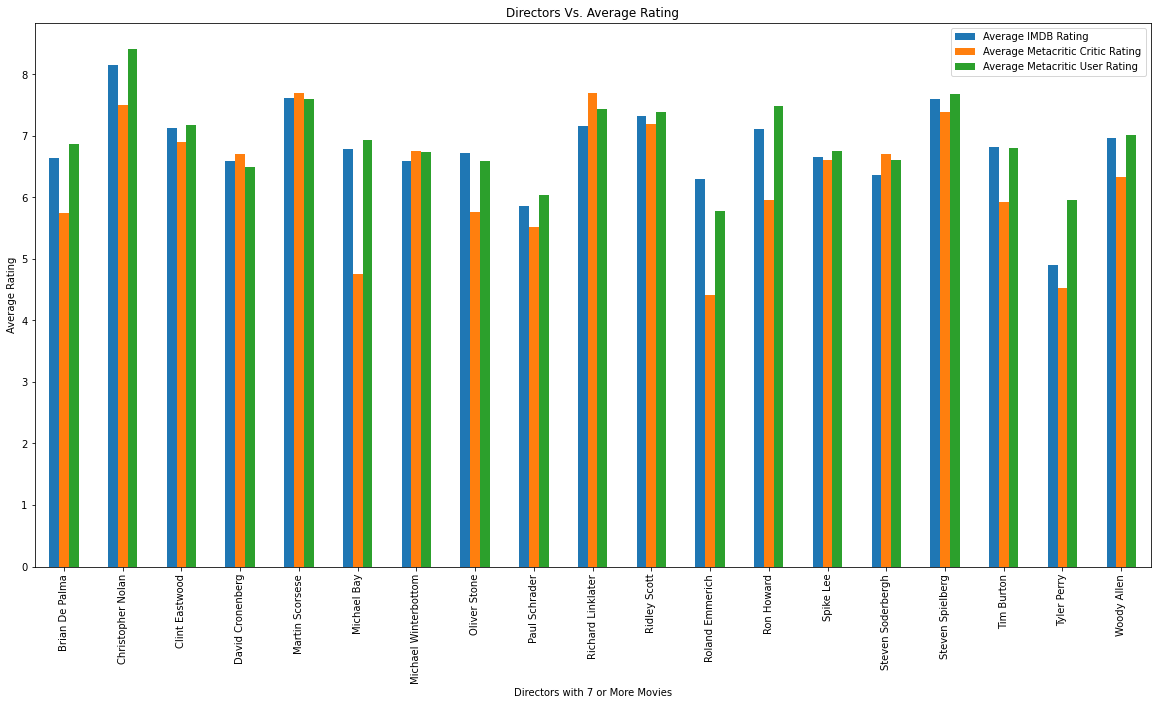

In [6]:
# Ensure that there are no missing values for directors or IMDB ratings. We don't need to check that Metacritic ratings are missing as we only merged rows from the metacritic dataframe without missing values.
director_rating_df = merged.dropna(subset=['director', 'avg_vote'])

# Get a list of all the directors
length = director_rating_df['director'].str.len()
values = director_rating_df['director'].values
indexRepetition = np.repeat(director_rating_df.index,length)
director_rating_df = director_rating_df.loc[indexRepetition]
director_rating_df['director'] = np.concatenate(values)
director_rating_df = director_rating_df.reset_index(drop=True)

# Get the averages of all the ratings from imdb, metacriritc critic, metacritic user for each director
director_count = director_rating_df.groupby(['director'])['title'].count()
director_average_vote = director_rating_df.groupby(['director'])['avg_vote'].mean()
director_critic_rating = director_rating_df.groupby(['director'])['metacritic_critic_rating'].mean()
director_user_rating = director_rating_df.groupby(['director'])['metacritic_user_rating'].mean()

# Create a pandas datafram with all directors and their ratings
director_stats_imdb = pd.merge(director_count,director_average_vote,on='director').rename(columns = {'title':'count_movies','avg_vote':'Average IMDB Rating'})
director_stats_critic_rating = pd.merge(director_stats_imdb,director_critic_rating, on = 'director').rename(columns = {'title':'count_movies','metacritic_critic_rating':'Average Metacritic Critic Rating'})
director_stats_user_rating = pd.merge(director_stats_critic_rating,director_user_rating, on = 'director').rename(columns = {'title':'count_movies','metacritic_user_rating':'Average Metacritic User Rating'})

# Ratings of movies for directors who have directed more than 7 movies have been displayed in the graph
director_stats = director_stats_user_rating.loc[director_stats_user_rating['count_movies']>=7,:].copy()
director_rating_stats = pd.DataFrame(director_stats).reset_index()
director_rating_stats = director_rating_stats.drop(['count_movies'],axis = 1)

# Plot a bar graph to display the average ratings for the three different types of ratings for a director who has 7 or more movies
graph = director_rating_stats.plot.bar(x = 'director', figsize = (20,10), xlabel = 'Directors with 7 or More Movies', ylabel = 'Average Rating', title = 'Directors Vs. Average Rating')

From the above graph, we can determine which directors lead to a higher rated movie on average. In this case, Christopher Nolan's movies have the highest average ratings. However, the average ratings alone don't tell us whether a director's movies consistently had high ratings, or they had some highly rated movies to offset some lower rated ones. To analyze this, we plotted standard deviation of each rating for each director with 7 or more movies.

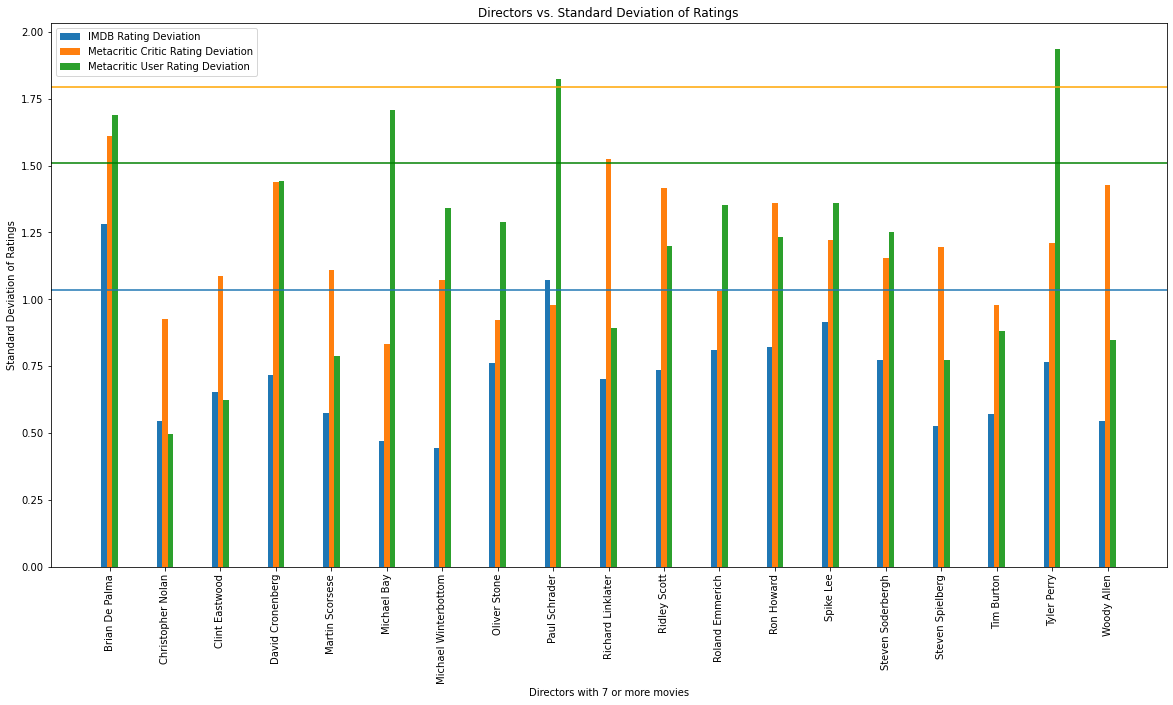

In [7]:
import matplotlib.pyplot as plt

# Get the standard deviation of all the ratings for each type of rating
director_average_vote_deviation = director_rating_df.groupby(['director'])['avg_vote'].std()
director_critic_rating_deviation = director_rating_df.groupby(['director'])['metacritic_critic_rating'].std()
director_user_rating_deviation = director_rating_df.groupby(['director'])['metacritic_user_rating'].std()

# Create a pandas datafram for the directors and thier standard deviation of ratings for 3 different types of ratings
director_stats_imdb_deviation = pd.merge(director_count,director_average_vote_deviation,on='director').rename(columns = {'title':'count_movies','avg_vote':'IMDB Average Rating Deviation'})
director_stats_critic_rating_deviation = pd.merge(director_stats_imdb_deviation,director_critic_rating_deviation, on = 'director').rename(columns = {'title':'count_movies','metacritic_critic_rating':'Metacritic Critic Rating Deviation'})
director_stats_user_rating_deviation = pd.merge(director_stats_critic_rating_deviation,director_user_rating_deviation, on = 'director').rename(columns = {'title':'count_movies','metacritic_user_rating':'Metacritic User Rating Deviation'})

# Filter the datafram for directors who have directed 7 or more movies
director_stats_deviation = director_stats_user_rating_deviation.loc[director_stats_user_rating_deviation['count_movies']>=7,:].copy()
director_rating_stats_deviation = pd.DataFrame(director_stats_deviation).reset_index()
director_rating_stats_deviation = director_rating_stats_deviation.drop(['count_movies'],axis = 1)

# Create 3 bars for bar graph, each bar is associated with it's rating type and standard deviation
fig,ax= plt.subplots(figsize = (20,10))
width = 0.1
x = np.arange(len(director_rating_stats_deviation['director']))
rects1 = ax.bar(x,director_rating_stats_deviation['IMDB Average Rating Deviation'], width, label = "IMDB Rating Deviation")
rects2 = ax.bar(x+width, director_rating_stats_deviation['Metacritic Critic Rating Deviation'], width, label="Metacritic Critic Rating Deviation")
rects3 = ax.bar(x + 2*width,director_rating_stats_deviation['Metacritic User Rating Deviation'],width,label="Metacritic User Rating Deviation")

# Set the labels and ticks for the bar graph
ax.set_ylabel("Standard Deviation of Ratings")
ax.set_xlabel("Directors with 7 or more movies")
ax.set_title('Directors vs. Standard Deviation of Ratings')
ax.set_xticks(x+width)
ax.set_xticklabels(director_rating_stats_deviation['director'], rotation = "vertical")
ax.legend()

# Create standard deviation average lines for the 3 different types of ratings
std_imdb = director_rating_df['avg_vote'].std()
std_critic = director_rating_df['metacritic_critic_rating'].std()
std_user = director_rating_df['metacritic_user_rating'].std()
ax.axhline(std_imdb)
ax.axhline(std_critic, color = "orange")
ax.axhline(std_user, color = "green")

# Show the bar graph
plt.show()

The standard deviation in the ratings lets us know how much variation there was in the ratings of directors' movies. In other words, it lets us know whether directors' movies performed consistently when considering movie ratings. As the standard deviation of each rating for each director was generally less than the corresponding standard deviation of the ratings of all movies (horizontal lines), it can be concluded that directors usually have consistent ratings, and thus directors affect the ratings of movies. 

## How do the ratings of a movie affect its income?
To answer this question, a scatter plot is used to show all ratings from each type of rating: Metacritic critics, Metacritic users, and IMDB ratings. The worldwide gross income of movies is used since this would already include the US gross income.

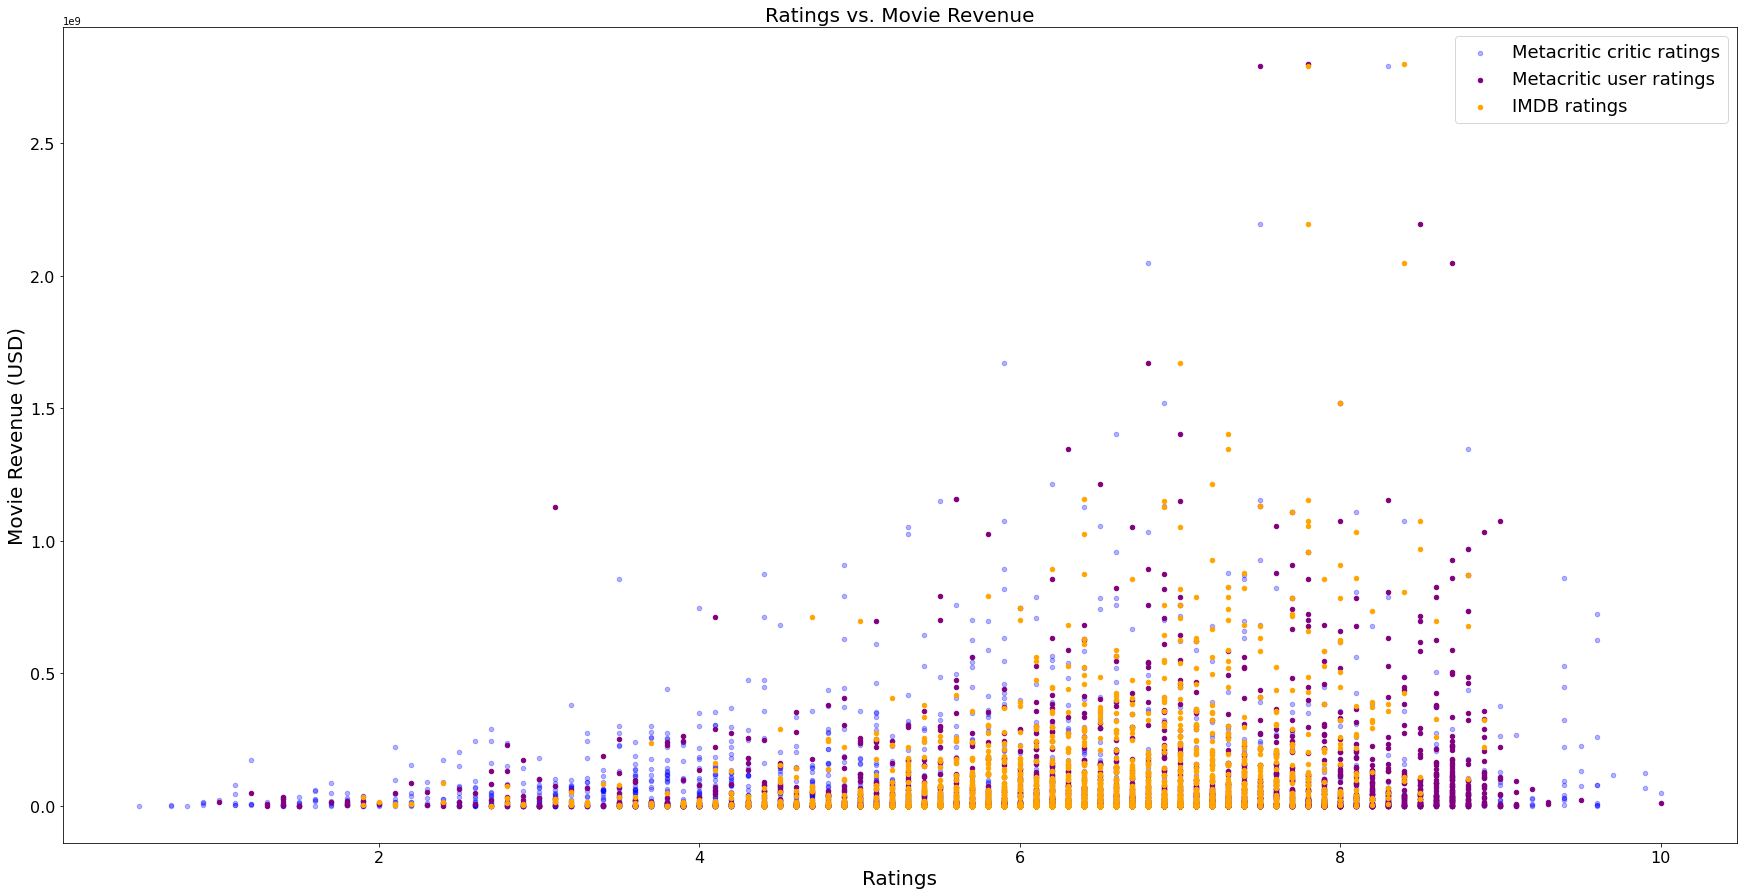

In [8]:
# Ensure that there are no missing values for worldwide gross income and IMDB ratings. We don't need to check that Metacritic ratings are missing as we only merged rows from the metacritic dataframe without missing values.
rating_income_df = merged.dropna(subset=['worldwide_gross_income', 'avg_vote'])

#Since we are comparing all the data points, simply get all rows without filters
vote_stats = rating_income_df[['metacritic_critic_rating', 'avg_vote', 'metacritic_user_rating', 'worldwide_gross_income']]
vote_stats = vote_stats.sort_values(by='avg_vote', ascending=False)

#Creating scatter plot for three series
plot = vote_stats.plot.scatter(label = "Metacritic critic ratings",x='metacritic_critic_rating', y ='worldwide_gross_income', title="Ratings vs. Movie Revenue", color='blue', legend = True, alpha= 0.3, figsize = (30,15), fontsize =16)
vote_stats.plot.scatter(label = "Metacritic user ratings",x='metacritic_user_rating', y='worldwide_gross_income', color='purple', ax=plot)    
vote_stats.plot.scatter(label = "IMDB ratings",x='avg_vote', y='worldwide_gross_income', color='orange', ax=plot)

#Setting visual properties of the scatter plot
plot.set_xlabel("Ratings")
plot.set_ylabel("Movie Revenue (USD)")
plot.xaxis.label.set_size(20)
plot.yaxis.label.set_size(20)
plot.title.set_size(20)
plot = plot.legend(prop=dict(size=18))

From the scatter plot above, it can be said that the ratings of a movie have some impact on the revenue of a movie. Generally, if a movie has lower ratings (less than roughly 6), the movie will generate less revenue. However, if a movie has higher ratings (more than roughly 6), it can't be predicted whether the movie will generate low or high revenue. 

## How do the lead actors of a movie affect its income?
Since there are many actors listed, the following bar chart only takes into account actors who have been in 14 or more movies. For this question, we examine income in only the US, as well as worldwide.

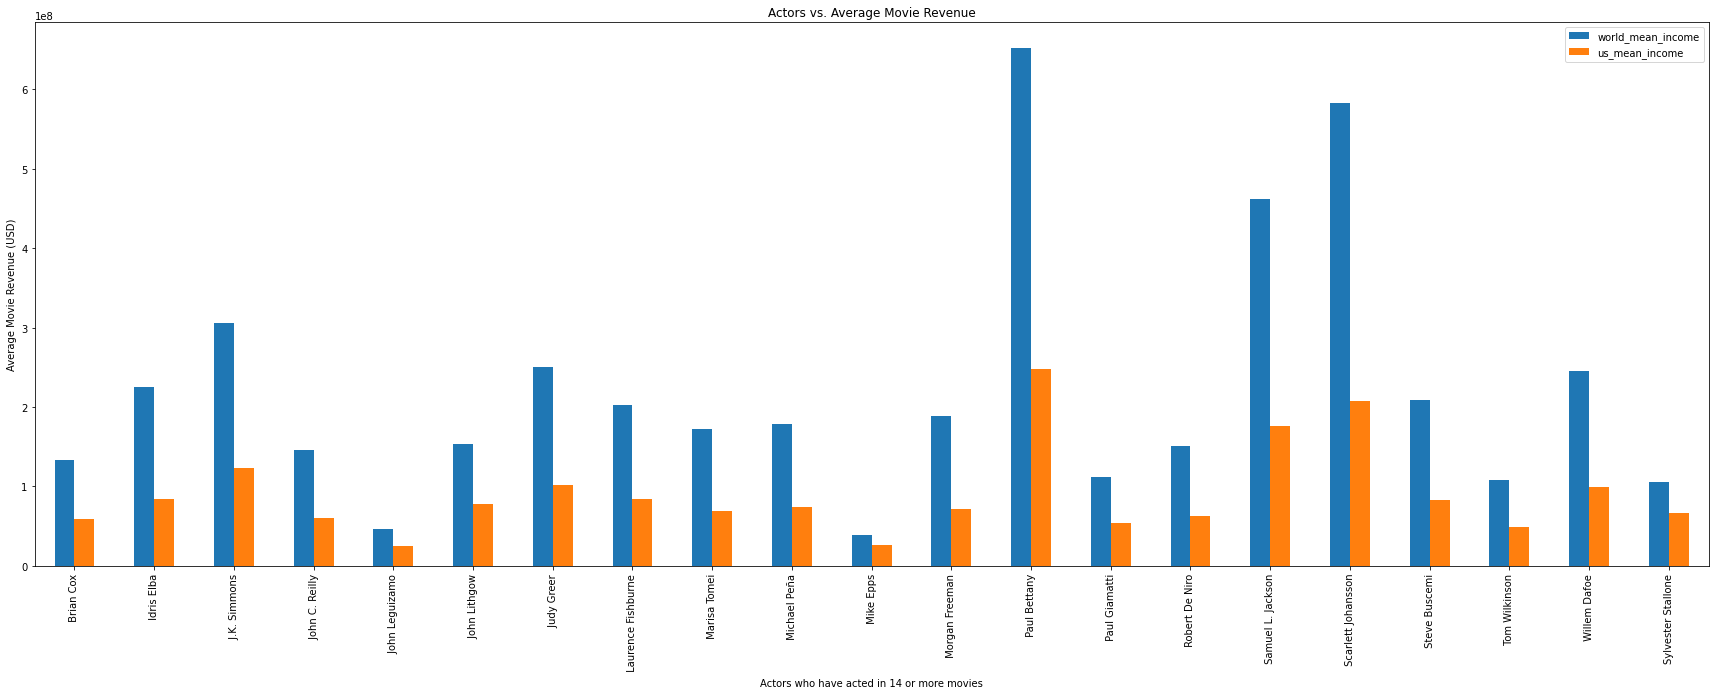

In [9]:
# Ensure that there are no missing values for worldwide gross and USA gross incomes and actors
actor_income_df = merged.dropna(subset=['worldwide_gross_income', 'usa_gross_income', 'actors'])

#First, get the gross worldwide/US incomes, and actors. Since actors are in an array, display each actor as a separate row.
stats = actor_income_df[['actors', 'worldwide_gross_income','usa_gross_income']]
actor_len = stats.actors.str.len()
actors_values = stats.actors.values
new_indexes = np.repeat(stats.index, actor_len)
stats = stats.loc[new_indexes]
stats['actors'] = np.concatenate(actors_values)
stats = stats.reset_index(drop=True).fillna(0)

#Group by the actors and get the mean of both gross incomes, and count of rows for each actor.
stats = stats.groupby(['actors']).agg(['mean', 'count'])
stats.columns = stats.columns.get_level_values(0)
stats.columns = ['world_mean_income', 'us_count','us_mean_income',  'count']

#Since there are too many actors, only look at actors that have been in 14 or more movies.
stats = stats.loc[stats['count'] >= 14]


#Only get the mean incomes of the above dataframe
stats = stats[['world_mean_income','us_mean_income']]

#Plot a bar chart
barchart = stats.plot.bar(figsize = (30,10), xlabel = 'Actors who have acted in 14 or more movies', ylabel = 'Average Movie Revenue (USD)', title = 'Actors vs. Average Movie Revenue')

From the above graph, we can determine which actors lead to a movie generating higher revenue. In this case, Paul Bettany's movies generate the highest revenue both in the US and worldwide. However, the average revenue alone doesn't tell us whether an actor's movies consistently generated higher revenue, or they had some better peforming movies to offset some lower performing ones. To analyze this, we plotted standard deviation of the revenue for each actor with 14 or more movies.

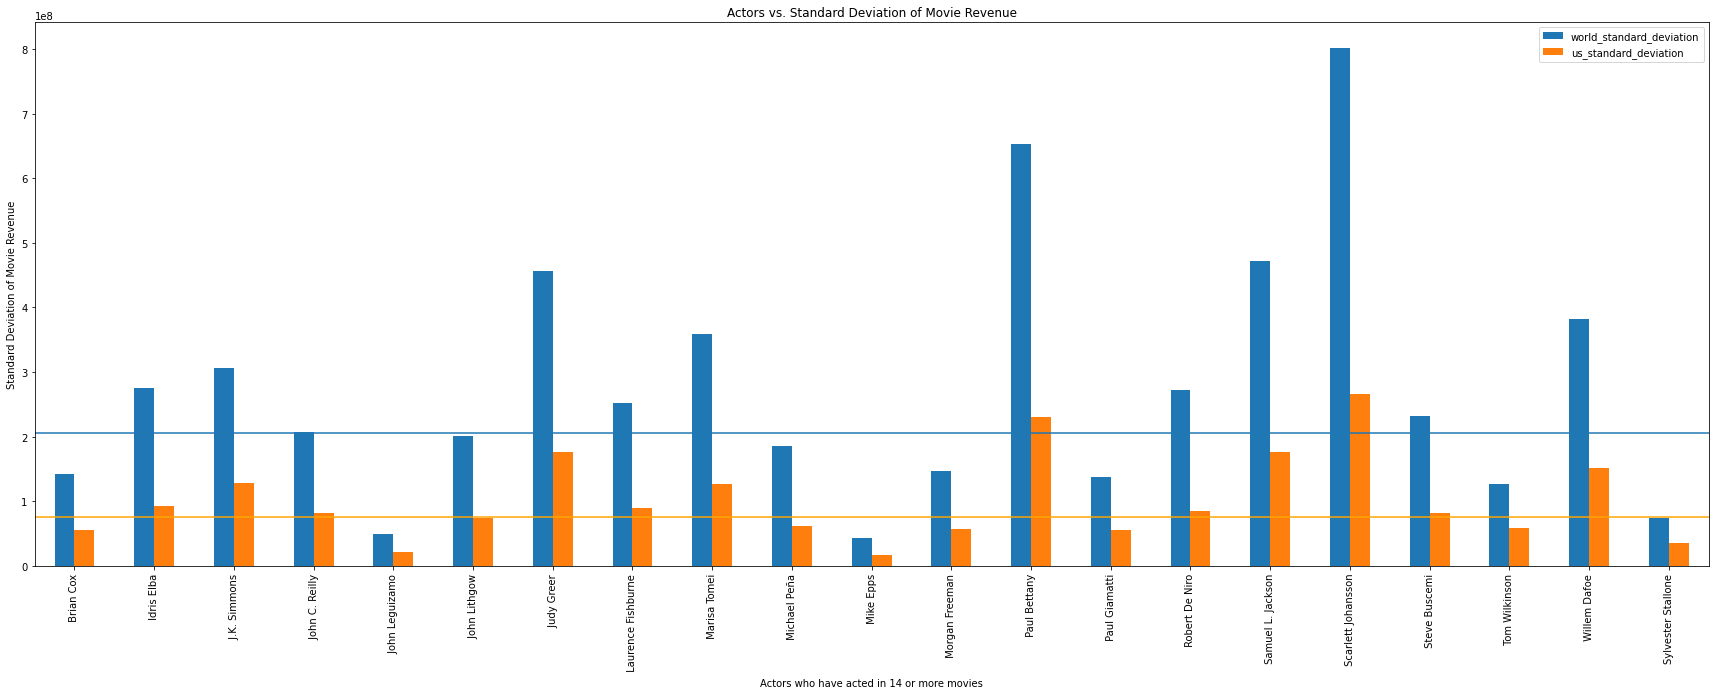

In [10]:
#goal is to display the standard deviation of the incomes to see how accurate the mean movie incomes are in the first grid

#Same procedure as above chart, first get the actors and their corresponding movie incomes.
stats = actor_income_df[['actors', 'worldwide_gross_income','usa_gross_income']]
actor_len = stats.actors.str.len()
actors_values = stats.actors.values
new_indexes = np.repeat(stats.index, actor_len)
stats = stats.loc[new_indexes]
stats['actors'] = np.concatenate(actors_values)
stats = stats.reset_index(drop=True).fillna(0)

#Group by actors and determine the standard deviation of US and worldwide move incomes
stats = stats.groupby(['actors']).agg(['std', 'count'])
stats.columns = stats.columns.get_level_values(0)
stats.columns = ['world_standard_deviation', 'us_count','us_standard_deviation',  'count']

#Sort the worldwide standard deviations in descending order,
#and take into account onyl actors who have been in 14 or more movies
stats = stats.loc[stats['count'] >= 14]

#Creating bar chart from dataframe subset
stats = stats[['world_standard_deviation','us_standard_deviation']]
barchart = stats.plot.bar(figsize = (30,10), xlabel = 'Actors who have acted in 14 or more movies', ylabel = 'Standard Deviation of Movie Revenue', title = 'Actors vs. Standard Deviation of Movie Revenue')

# use axhline to show the mean standard deviations for each series
world_std = actor_income_df["worldwide_gross_income"].std()
us_std = actor_income_df["usa_gross_income"].std()
barchart.axhline(world_std)
barchart = barchart.axhline(us_std, color ="orange")

The standard deviation in the revenue lets us know how much variation there was in the revenue generated by actors' movies. In other words, it lets us know whether actors' movies performed consistently when considering revenue. As the standard deviation in revenue for each actor's movies was generally similar to the standard deviation in the revenue of all movies (horizontal lines), it can't be concluded that actors generate a consistent revenue across all movies they work in, and thus it can't be said that actors affect the revenue of movies.